In [ ]:
# cd to root of folder

In [ ]:
import pickle
!pip install --user scikit-misc
!pip install anndata
import anndata
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
name = "Psoriasis_gse171012_pca20"
# name = "COVID_gse212041_pca50"
# name = "Crohn_gse112366_pca20"
name_key = name.split('_')[0]
score = None  # 'acuity' for COVID, 'PASI_scores' for psoriaris
adata = anndata.read_h5ad(f"/content/drive/MyDrive/Colab Notebooks/{name}.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 55 × 16369
    obs: 'geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue', 'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name', 'PASI_score', 'leiden', 'visit', 'timepoint'
    var: 'feature_name', 'id'
    uns: 'gsea_go', 'gsea_hubmap', 'kstest', 'leiden_', 'n_gene_id_to_name_failed', 'pipeline', 'visit_order', 'x_pca_'
    obsm: 'x_pca', 'x_umap'
    varm: 'healthy'
    obsp: 'umap_affinity', 'umap_connectivity', 'umap_distance'


## Data Preparation for Diffusion Models

This section prepares the AnnData object for use with diffusion models. This typically involves normalization, dimensionality reduction, and converting the data to a tensor format suitable for deep learning frameworks.

### Normalization and Log-Transformation

We will normalize the data to a total count of 10,000 reads per cell and then apply a log1p transformation. This helps to account for differences in sequencing depth and stabilize variance.

### Dimensionality Reduction (PCA)

Diffusion models can be computationally expensive in high dimensions. We will use Principal Component Analysis (PCA) to reduce the feature space while retaining most of the variance. We'll use 50 components, as was done in the original AnnData object creation.

In [ ]:
!pip install scanpy
import scanpy as sc
import torch
import numpy as np

# Create a copy of the AnnData object to avoid modifying the original
adata_processed = adata.copy()

# Normalization: total count normalize to 1e4
sc.pp.normalize_total(adata_processed, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata_processed)

print("Data normalized and log-transformed:")
print(adata_processed)

Data normalized and log-transformed:
AnnData object with n_obs × n_vars = 55 × 16369
    obs: 'geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue', 'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name', 'PASI_score', 'leiden', 'visit', 'timepoint'
    var: 'feature_name', 'id'
    uns: 'gsea_go', 'gsea_hubmap', 'kstest', 'leiden_', 'n_gene_id_to_name_failed', 'pipeline', 'visit_order', 'x_pca_', 'log1p'
    obsm: 'x_pca', 'x_umap'
    varm: 'healthy'
    obsp: 'umap_affinity', 'umap_connectivity', 'umap_distance'


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:391: RuntimeWarning: invalid value encountered in log1p
  np.log1p(x, out=x)


In [ ]:
print(adata_processed)

AnnData object with n_obs × n_vars = 55 × 16369
    obs: 'geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue', 'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name', 'PASI_score', 'leiden', 'visit', 'timepoint'
    var: 'feature_name', 'id'
    uns: 'gsea_go', 'gsea_hubmap', 'kstest', 'leiden_', 'n_gene_id_to_name_failed', 'pipeline', 'visit_order', 'x_pca_', 'log1p'
    obsm: 'x_pca', 'x_umap'
    varm: 'healthy'
    obsp: 'umap_affinity', 'umap_connectivity', 'umap_distance'


In [ ]:
# Perform PCA to reduce dimensionality. Use n_comps=50 as in the original adata.
sc.tl.pca(adata_processed, n_comps=50)

print("\nPCA performed. The reduced data is in adata_processed.obsm['x_pca']:")
print(adata_processed.obsm['x_pca'].shape)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Convert to Tensors

Finally, we convert the PCA-reduced data and relevant categorical metadata (like 'clinical_status' and 'timepoint') into PyTorch tensors. Categorical data will be converted to numerical labels first.

In [ ]:
# Convert PCA coordinates to a PyTorch tensor
data_tensor = torch.tensor(adata_processed.obsm['x_pca'], dtype=torch.float32)

# Prepare conditional information (e.g., clinical status and timepoint)
# Convert categories to numerical labels
clinical_status_labels = adata_processed.obs['clinical_status'].astype('category').cat.codes.values
timepoint_labels = adata_processed.obs['timepoint'].astype('category').cat.codes.values

# Convert numerical labels to tensors
clinical_status_tensor = torch.tensor(clinical_status_labels, dtype=torch.long)
timepoint_tensor = torch.tensor(timepoint_labels, dtype=torch.long)

print("\nData converted to PyTorch tensors:")
print("Data tensor shape:", data_tensor.shape)
print("Clinical status tensor shape:", clinical_status_tensor.shape)
print("Timepoint tensor shape:", timepoint_tensor.shape)

# These tensors (data_tensor, clinical_status_tensor, timepoint_tensor)
# can now be used to create a PyTorch Dataset and DataLoader for training
# a diffusion model.


Data converted to PyTorch tensors:
Data tensor shape: torch.Size([55, 20])
Clinical status tensor shape: torch.Size([55])
Timepoint tensor shape: torch.Size([55])


tensor([[ 61.5253,  50.4903,  58.9282,  ...,  33.0035,  44.3640, -20.7297],
        [ 58.5427, -40.9023, 116.0187,  ..., -20.8081,  -9.0249, -19.2627],
        [ 12.8934, -35.6675,  66.9120,  ...,  15.9415,  -6.5525,  17.2424],
        ...,
        [ 46.1599, -23.4169, -13.7445,  ...,  -5.4955,   1.5203,  -6.0700],
        [132.8024, 184.6093, -70.3533,  ...,  -5.0625,  -1.0578,   6.1502],
        [ 77.4661, -23.0135, -26.4864,  ...,   4.4388,  -3.9682, -11.2308]])


Explore Data for Psoriasis

Now, we need to normalize the data

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_tensor = data_tensor.float().to(device)              # [55, 20]
clinical_status_tensor = clinical_status_tensor.long().to(device)  # [55]
timepoint_tensor = timepoint_tensor.float().to(device) # [55]

In [ ]:
x_mean = data_tensor.mean(dim=0, keepdim=True)
x_std  = data_tensor.std(dim=0, keepdim=True) + 1e-6
X_norm = (data_tensor - x_mean) / x_std


In [ ]:
class ClinicalDataset(Dataset):
    def __init__(self, X, y, t):
        self.X = X
        self.y = y
        self.t = t

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.t[idx]

dataset = ClinicalDataset(X_norm, clinical_status_tensor, timepoint_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
T = 1000  # number of diffusion steps

betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def get_alpha_hat(t_idx):
    # t_idx: [batch] int64 in [0, T-1]
    return alphas_cumprod[t_idx].view(-1, 1)  # [batch, 1]


In [ ]:
def q_sample(x0, t_idx, noise=None):
    """
    x0: [B, D]
    t_idx: [B] integer timesteps
    """
    if noise is None:
        noise = torch.randn_like(x0)
    alpha_hat = get_alpha_hat(t_idx)  # [B,1]
    return torch.sqrt(alpha_hat) * x0 + torch.sqrt(1 - alpha_hat) * noise, noise


In [ ]:
class EpsModel(nn.Module):
    def __init__(self, x_dim=20, n_classes=None, hidden_dim=128, t_embed_dim=16):
        super().__init__()

        # time embedding: simple sin/cos or linear proj of scalar t/T
        self.t_embed = nn.Sequential(
            nn.Linear(1, t_embed_dim),
            nn.SiLU(),
            nn.Linear(t_embed_dim, t_embed_dim),
        )

        # clinical status embedding (optional)
        if n_classes is not None:
            self.y_embed = nn.Embedding(n_classes, t_embed_dim)
        else:
            self.y_embed = None

        in_dim = x_dim + t_embed_dim
        if self.y_embed is not None:
            in_dim += t_embed_dim

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, x_dim),
        )

    def forward(self, x_t, t_idx, y=None, obs_time=None):
        """
        x_t: [B, 20]
        t_idx: [B] diffusion step indices
        y: [B] clinical status
        obs_time: [B] original clinical timepoint (optional)
        """
        # normalize t_idx to [0,1]
        t = t_idx.float().unsqueeze(-1) / (T - 1)
        t_feat = self.t_embed(t)

        feats = [x_t, t_feat]

        if self.y_embed is not None and y is not None:
            y_feat = self.y_embed(y)
            feats.append(y_feat)

        # If you want to use obs_time as well, add another small MLP here.
        # (or replace t_idx-based conditioning with obs_time-based)

        h = torch.cat(feats, dim=-1)
        eps_hat = self.net(h)
        return eps_hat

n_classes = int(clinical_status_tensor.max().item() + 1)  # or set directly
model = EpsModel(x_dim=20, n_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [ ]:
import math

def sample_timesteps(batch_size):
    return torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)

n_epochs = 2000  # tiny data, so small; watch for overfit

for epoch in range(n_epochs):
    for x0, y, t_obs in loader:
        model.train()
        optimizer.zero_grad()

        # sample random diffusion step for each example
        t_idx = sample_timesteps(x0.size(0))  # [B]

        x_t, noise = q_sample(x0, t_idx)     # forward diffusion

        eps_hat = model(x_t, t_idx, y=y, obs_time=t_obs)
        loss = criterion(eps_hat, noise)

        loss.backward()
        optimizer.step()

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, loss={loss.item():.4f}")


Epoch 200/2000, loss=0.3593
Epoch 400/2000, loss=0.2553
Epoch 600/2000, loss=0.3878
Epoch 800/2000, loss=0.2031
Epoch 1000/2000, loss=0.1001
Epoch 1200/2000, loss=0.1902
Epoch 1400/2000, loss=0.1211
Epoch 1600/2000, loss=0.2325
Epoch 1800/2000, loss=0.0827
Epoch 2000/2000, loss=0.1061


In [ ]:
@torch.no_grad()
def p_sample_step(x_t, t_idx, y=None, obs_time=None):
    """
    One reverse step: x_t -> x_{t-1}
    t_idx: int scalar or [B]
    """
    if isinstance(t_idx, int):
        t_idx = torch.full((x_t.size(0),), t_idx, device=device, dtype=torch.long)

    beta_t = betas[t_idx].view(-1, 1)
    alpha_t = alphas[t_idx].view(-1, 1)
    alpha_hat_t = alphas_cumprod[t_idx].view(-1, 1)

    eps_hat = model(x_t, t_idx, y=y, obs_time=obs_time)

    # DDPM mean formula
    mean = (1 / torch.sqrt(alpha_t)) * (
        x_t - beta_t / torch.sqrt(1 - alpha_hat_t) * eps_hat
    )

    # no noise at t=0
    noise = torch.randn_like(x_t) if (t_idx[0] > 0) else torch.zeros_like(x_t)

    return mean + torch.sqrt(beta_t) * noise

@torch.no_grad()
def sample(num_samples, y_cond=None, obs_time_cond=None):
    x_t = torch.randn(num_samples, 20, device=device)  # start from noise

    # broadcast conditioning
    if y_cond is not None:
        y_cond = y_cond.to(device)
        if y_cond.dim() == 0:
            y_cond = y_cond.repeat(num_samples)
    if obs_time_cond is not None:
        obs_time_cond = obs_time_cond.to(device).float()
        if obs_time_cond.dim() == 0:
            obs_time_cond = obs_time_cond.repeat(num_samples)

    for t_step in reversed(range(T)):
        x_t = p_sample_step(x_t, t_step, y=y_cond, obs_time=obs_time_cond)

    # denormalize back to original scale
    x_gen = x_t * x_std + x_mean
    return x_gen

# Example: generate 10 samples for clinical status = 1
y_cond = torch.tensor(1)
generated = sample(10, y_cond=y_cond)
print(generated.shape)  # [10, 20]


torch.Size([10, 20])


In [ ]:
generated

tensor([[ 7.7710e+00, -3.6630e+01, -1.1794e+01, -2.7130e+01, -1.7897e-01,
         -6.7756e+00,  2.2455e+00,  1.1710e+01, -2.6405e+01, -9.3533e+00,
          1.2131e+01, -1.5220e+01, -1.1758e+01,  4.9189e+00, -1.2970e+01,
         -5.5607e+00,  4.7330e+00,  6.2131e-01,  2.9894e+00, -2.1834e+01],
        [-3.9618e+02, -2.0045e+02, -1.4992e+01, -2.0801e+02,  3.5077e+02,
          6.4229e+01, -1.8711e+02,  9.7819e+01,  8.2913e+00,  6.8537e+01,
          4.0185e+01,  5.5013e+01, -1.8314e+01, -6.4601e+01,  2.4061e+01,
         -7.2742e+00,  5.2496e+00, -5.6663e+01, -3.6614e+01,  5.9912e+00],
        [ 1.9021e+01, -9.0416e+00,  7.2840e+00, -2.8142e+01, -2.6381e+01,
          7.0731e-01,  8.9417e+00,  1.2210e+01, -1.5095e+01,  3.7568e+00,
         -7.3106e-01,  6.3089e+00, -2.0505e+00,  4.8039e+00,  1.0461e+01,
         -1.0339e+01,  1.3224e+01, -7.6068e+00, -2.9195e+00,  1.0130e+01],
        [-1.0092e+00,  1.3977e+01, -1.6271e+01, -9.6262e+00, -2.5958e+01,
          1.8377e+00, -2.7406e+00, 

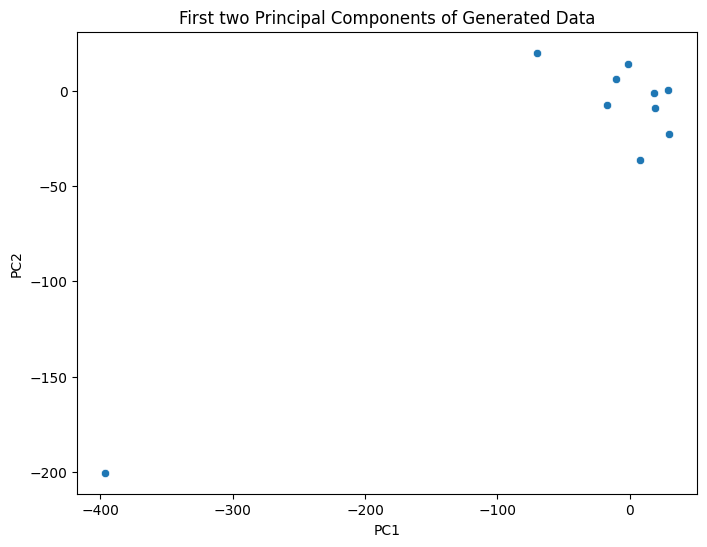

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the generated tensor to a numpy array
generated_data_np = generated.cpu().numpy()

# Create a DataFrame for easier plotting
generated_plot_df = pd.DataFrame(generated_data_np, columns=[f'PC{i+1}' for i in range(generated_data_np.shape[1])])

# Plot the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=generated_plot_df, x='PC1', y='PC2')
plt.title('First two Principal Components of Generated Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

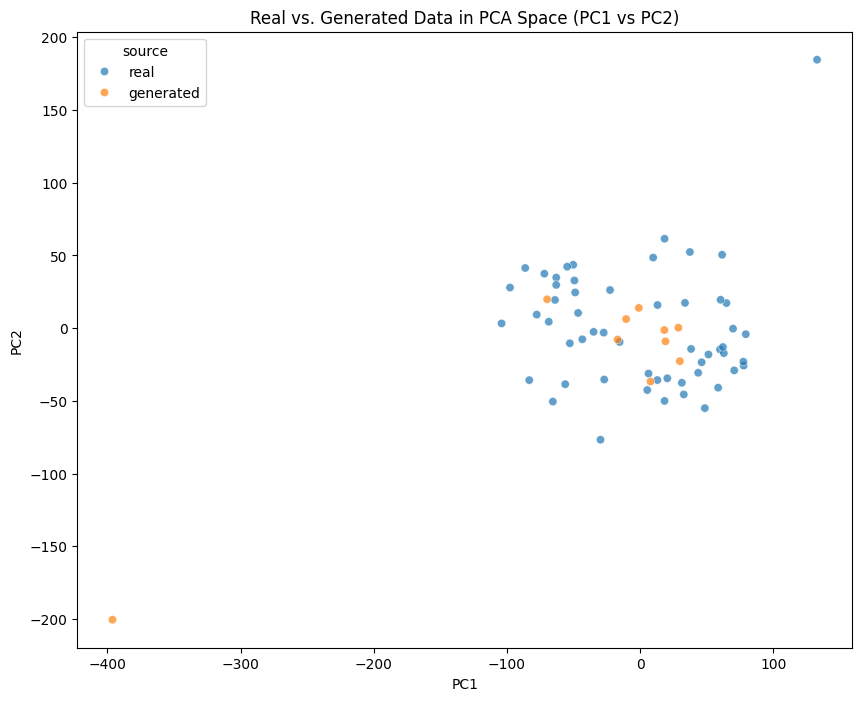

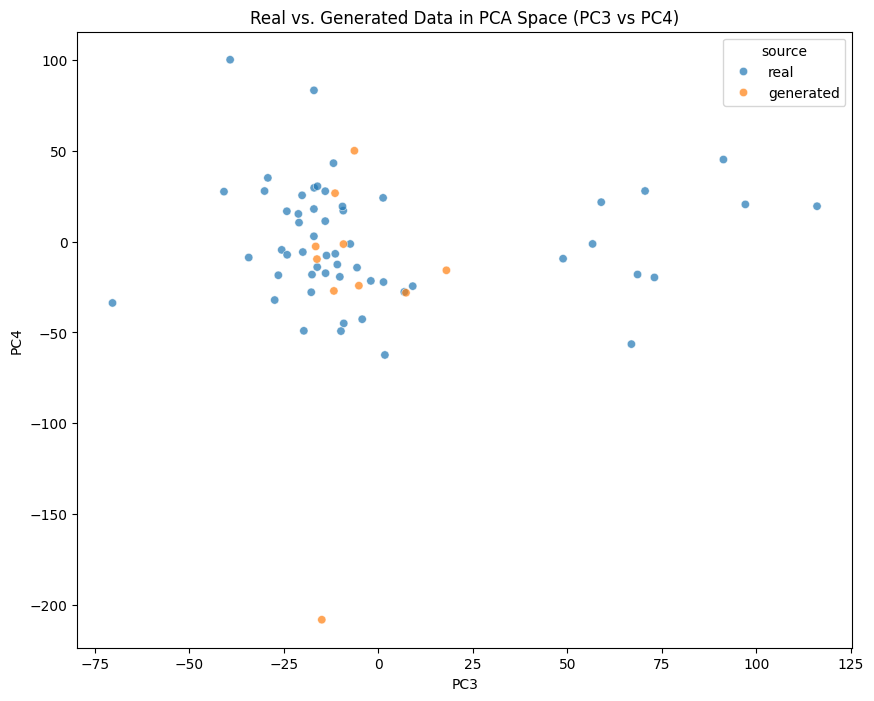

In [ ]:
# Combine real and generated data for visualization
# Make sure the generated data is on the CPU for combining with pandas DataFrame
generated_data_cpu = generated.cpu().numpy()

# Create a pandas DataFrame for the generated data (optional, for easier handling)
generated_df = pd.DataFrame(generated_data_np, columns=[f'PC{i+1}' for i in range(generated_data_np.shape[1])])
generated_df['source'] = 'generated'
# Add clinical status and timepoint for generated data if you conditioned on them during sampling
# For example, if you sampled with y_cond=torch.tensor(1):
# generated_df['clinical_status'] = adata.obs['clinical_status'].cat.categories[1]
# generated_df['timepoint'] = 'N/A' # or a specific timepoint if you conditioned on it

# Get the real PCA data and add a source column
real_pca_df = pd.DataFrame(adata.obsm['x_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['x_pca'].shape[1])])
real_pca_df['source'] = 'real'
# Include clinical status and timepoint for real data
real_pca_df['clinical_status'] = adata.obs['clinical_status'].values
real_pca_df['timepoint'] = adata.obs['timepoint'].values


# Concatenate the real and generated data
combined_df = pd.concat([real_pca_df, generated_df], ignore_index=True)

# You can now use this combined_df to visualize the data.
# For example, using seaborn:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined_df, x='PC1', y='PC2', hue='source', alpha=0.7)
plt.title('Real vs. Generated Data in PCA Space (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# You can also try plotting other PCs
plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined_df, x='PC3', y='PC4', hue='source', alpha=0.7)
plt.title('Real vs. Generated Data in PCA Space (PC3 vs PC4)')
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.show()

## Diffusion Model Evaluation

Now that the diffusion model has been trained, we need to evaluate its performance. Evaluation metrics for generative models can assess the quality and diversity of generated samples, as well as how well they match the distribution of the real data.

### Evaluation Metrics

Here are some potential evaluation metrics we can use:

*   **Visual Inspection:** Comparing visualizations (like the PCA plots we already generated) of real and generated data is a good first step.
*   **Statistical Comparisons:** Comparing statistical properties (mean, variance, distributions of features) between real and generated data, as we just did, provides a quantitative assessment.
*   **Distribution Matching:** Metrics like Maximum Mean Discrepancy (MMD) or the Fréchet Inception Distance (FID) (though FID is more common for images, variations exist for other data types) can quantify the similarity between the real and generated data distributions.
*   **Downstream Task Performance:** If the model is intended for a specific application (e.g., data augmentation for classification), evaluating the performance of a downstream model trained on the generated data can be informative.
*   **Qualitative Assessment related to biological context:** For biological data, evaluate if the generated data reflects known biological variations or relationships (e.g., distinct clusters for different cell types or conditions).

Given the nature of this dataset and the training on PCA components, focusing on visual inspection, statistical comparisons, and potentially distribution matching metrics adapted for this data type would be most relevant. We have already started with visual and basic statistical comparisons.

### Next Evaluation Steps

Let's continue with further quantitative evaluation. We can calculate and compare more detailed statistics or explore distribution matching metrics if suitable libraries are available in the environment.


Mean of real data (PCA):
PC1    -1.033517e-15
PC2    -2.390007e-15
PC3     5.296773e-15
PC4     1.937844e-16
PC5    -1.098112e-15
PC6     3.068253e-16
PC7    -6.943940e-16
PC8    -1.614870e-16
PC9    -7.186171e-16
PC10   -1.550275e-15
PC11    6.136505e-16
PC12   -1.744059e-15
PC13    2.196223e-15
PC14   -9.689219e-16
PC15    2.147777e-15
PC16   -2.067033e-15
PC17   -1.291896e-16
PC18   -8.074349e-16
PC19   -5.813531e-16
PC20   -8.720297e-16
dtype: float64

Mean of generated data (PCA):
PC1    -39.118275
PC2    -23.732891
PC3     -6.669171
PC4    -24.035971
PC5     19.288980
PC6      7.053538
PC7    -16.015947
PC8     20.839962
PC9     -9.473968
PC10     3.644823
PC11     4.127783
PC12    10.004327
PC13    -9.198969
PC14     1.573871
PC15     2.138198
PC16     0.677794
PC17     3.497916
PC18   -11.599133
PC19    -2.584180
PC20    -1.500505
dtype: float32

Standard deviation of real data (PCA):
PC1     57.834320
PC2     41.451936
PC3     38.589405
PC4     31.974160
PC5     26.389754
PC6

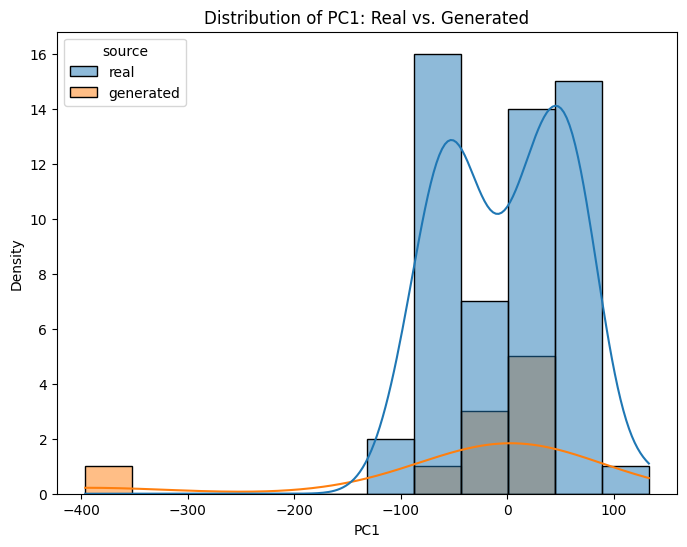

In [ ]:
# Calculate and compare means
real_mean = real_pca_df.drop(['source', 'clinical_status', 'timepoint'], axis=1).mean()
generated_mean = generated_df.drop('source', axis=1).mean()

print("\nMean of real data (PCA):")
print(real_mean)
print("\nMean of generated data (PCA):")
print(generated_mean)

# Calculate and compare standard deviations
real_std = real_pca_df.drop(['source', 'clinical_status', 'timepoint'], axis=1).std()
generated_std = generated_df.drop('source', axis=1).std()

print("\nStandard deviation of real data (PCA):")
print(real_std)
print("\nStandard deviation of generated data (PCA):")
print(generated_std)

# You could also plot distributions of individual principal components
# For example, distribution of PC1
plt.figure(figsize=(8, 6))
sns.histplot(data=combined_df, x='PC1', hue='source', kde=True)
plt.title('Distribution of PC1: Real vs. Generated')
plt.xlabel('PC1')
plt.ylabel('Density')
plt.show()

# Task
Perform exploratory data analysis (EDA) on the `adata` object.

## Check data dimensions

### Subtask:
Display the number of observations and variables in the `adata` object.


**Reasoning**:
Access and print the shape of the adata object to display the number of observations and variables.



In [ ]:
print(adata.shape)

(55, 16369)


## Explore observations (`obs`)

### Subtask:
Show the first few rows of the observations DataFrame to understand the sample annotations.


**Reasoning**:
Access and display the first few rows of the observations DataFrame to understand the sample annotations.



In [ ]:
display(adata.obs.head())

,geo_accession,seq_batch,seq_lane,subj,tissue,clinical_status,used_for_analysis,cell_type,smp_name,PASI_score,leiden,visit,timepoint
column_name,,,,,,,,,,,,,
NP1.04T.JC.002_N704.S506_S43_L006_R,GSM5216140,n062518,L006,N1,tissue: lesion,Psoriasis_SecukinumabTreatmentWeek12,used for analysis: TRUE,bulk,N1_Week12,1.7,3,Week12,3
NP1.04T.JC.002_N705.S507_S44_L006_R,GSM5216141,n062518,L006,N1,tissue: lesion,Psoriasis_SecukinumabTreatmentWeek4,used for analysis: TRUE,bulk,N1_Week4,1.5,2,Week4,2
NP1.04T.JC.002_N706.S508_S45_L006_R,GSM5216142,n062518,L006,N1,tissue: lesion,Psoriasis_PreTreatment,used for analysis: TRUE,bulk,N1_PreTreatment,12.4,2,PreTreatment,0
NP1.04T.JC.002_N707.S510_S46_L006_R,GSM5216143,n062518,L006,N1,tissue: lesion,Psoriasis_SecukinumabTreatmentWeek2,used for analysis: TRUE,bulk,N1_Week2,NaN,2,Week2,1
NP3.04T.AR.003_N711.S502_S60_L008_R,GSM5216144,n062518,L008,N3,tissue: lesion,Psoriasis_SecukinumabTreatmentWeek2,used for analysis: TRUE,bulk,N3_Week2,NaN,2,Week2,1


## Explore variables (`var`)

### Subtask:
Show the first few rows of the variables DataFrame to understand the gene information.


**Reasoning**:
Display the first few rows of the variables DataFrame to understand the gene information.



In [ ]:
display(adata.var.head())

,feature_name,id
TSPAN6,TSPAN6,ENSG00000000003
TNMD,TNMD,ENSG00000000005
DPM1,DPM1,ENSG00000000419
SCYL3,SCYL3,ENSG00000000457
C1orf112,C1orf112,ENSG00000000460


## Examine unstructured data (`uns`)

### Subtask:
Display the keys in the unstructured data dictionary to see what additional information is available.


**Reasoning**:
Display the keys of the unstructured data dictionary to see what additional information is available.



In [ ]:
print(adata.uns.keys())

dict_keys(['gsea_go', 'gsea_hubmap', 'kstest', 'leiden_', 'n_gene_id_to_name_failed', 'pipeline', 'visit_order', 'x_pca_'])


## Examine multidimensional annotations (`obsm`)

### Subtask:
Display the keys in the multidimensional annotations dictionary to see available embeddings like PCA or UMAP.


**Reasoning**:
Display the keys of the `adata.obsm` dictionary to see available embeddings like PCA or UMAP.



In [ ]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: x_pca, x_umap)


## Visualize data (optional)

### Subtask:
Visualize the UMAP embedding colored by the 'clinical_status' annotation to explore potential clustering based on this variable.


**Reasoning**:
Import the necessary plotting module from scanpy.



In [ ]:
!pip install scanpy
import scanpy as sc

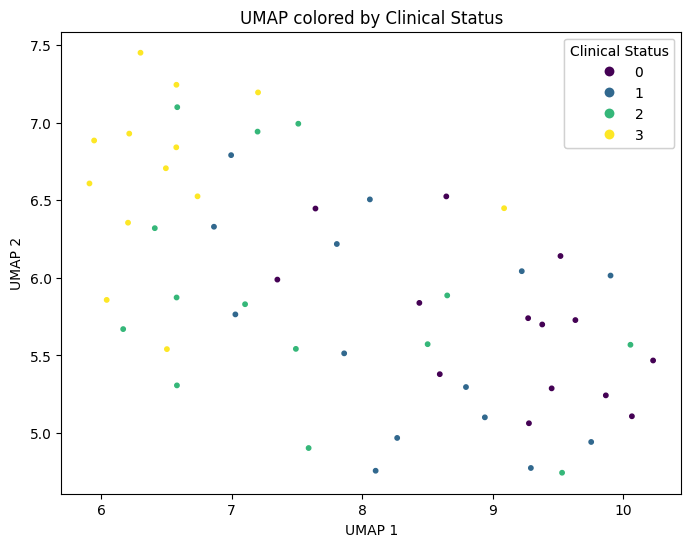

In [ ]:
import matplotlib.pyplot as plt

# Get UMAP coordinates and clinical status
umap_coords = adata.obsm['x_umap']
clinical_status = adata.obs['clinical_status']

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=clinical_status.cat.codes, cmap='viridis', s=10)

# Add a legend
legend = plt.legend(*scatter.legend_elements(), title='Clinical Status')
plt.gca().add_artist(legend)

plt.title('UMAP colored by Clinical Status')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
print(adata.obs.columns)
print(adata.obs['clinical_status'].dtype)

Index(['geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue',
       'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name',
       'PASI_score', 'leiden', 'visit', 'timepoint'],
      dtype='object')
category


In [ ]:
# Single-cell EDA quickscan for AnnData
# Assumes: import scanpy as sc; adata is loaded
import scanpy as sc
import numpy as np, pandas as pd, scipy.sparse as sp
from collections import Counter
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

print("==== BASIC ====")
print(adata)  # dims and dtype
n_cells, n_genes = adata.n_obs, adata.n_vars
is_sparse = sp.issparse(adata.X)
sparsity = 1.0 - (adata.X.nnz / (n_cells * n_genes)) if is_sparse else float(np.mean(adata.X == 0))
print(f"cells={n_cells:,}  genes={n_genes:,}  sparse={is_sparse}  sparsity≈{sparsity:0.3f}")

print("\nobs columns:", list(adata.obs.columns)[:15])
print("var columns:", list(adata.var.columns)[:15])

# Missingness
print("\n==== MISSINGNESS (obs/var) ====")
obs_na = adata.obs.isna().sum().sort_values(ascending=False)
var_na = adata.var.isna().sum().sort_values(ascending=False)
print("obs NA (top 10):"); print(obs_na[obs_na>0].head(10))
print("var NA (top 10):"); print(var_na[var_na>0].head(10))

# QC metrics: mitochondrial fraction, library size, detected genes
print("\n==== QC METRICS ====")
# attempt to detect mitochondrial genes by prefix
mt_prefixes = ("MT-","mt-","Mt-","Atp6","ATP6")  # add common mito markers if genes are not prefixed
mt_mask = pd.Series(adata.var_names).str.startswith(mt_prefixes).values
adata.var["mt"] = mt_mask  # harmless to add
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)
qc_cols = ["n_genes_by_counts","total_counts","pct_counts_mt"]
print(adata.obs[qc_cols].describe(percentiles=[.01,.05,.5,.95,.99]).round(2))

# Top expressed genes (by mean counts)
try:
    if sp.issparse(adata.X):
        gene_means = np.asarray(adata.X.mean(axis=0)).ravel()
    else:
        gene_means = adata.X.mean(axis=0)
    top_idx = np.argsort(gene_means)[::-1][:20]
    print("\nTop 20 genes by mean expression:");
    print(pd.DataFrame({"gene": adata.var_names[top_idx], "mean": gene_means[top_idx]}).reset_index(drop=True))
except Exception as e:
    print("Top-gene summary skipped:", e)

# Categorical summaries: show counts for likely label columns
print("\n==== CATEGORY COUNTS (top 8 categories each) ====")
cat_like = [c for c in adata.obs.columns
            if str(adata.obs[c].dtype) in ("category","object","bool")
            and adata.obs[c].nunique()<=100]
for c in cat_like[:8]:
    vc = adata.obs[c].astype("category").value_counts().head(10)
    print(f"\n{c} (n_levels={adata.obs[c].nunique()}):")
    print(vc)

# Highly variable genes
print("\n==== HIGHLY VARIABLE GENES ====")
hvg_info = None
if "highly_variable" in adata.var.columns:
    n_hvg = int(adata.var["highly_variable"].sum())
    print(f"Existing HVG flag found: {n_hvg} genes marked highly_variable")
else:
    hvg_info = sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", inplace=False)
    print(f"Computed HVGs (not modifying adata): {int(hvg_info['highly_variable'].sum())}")

# Plots: QC and highest expressed
print("\n==== PLOTS ====")
groupby = None
for cand in ["batch","sample","orig.ident","donor","subject","lane"]:
    if cand in adata.obs.columns:
        groupby = cand; break

# Violin plots for QC
sc.pl.violin(adata, ["n_genes_by_counts","total_counts","pct_counts_mt"], groupby=groupby, jitter=0.4, multi_panel=True, show=False)
# Distribution histograms
sc.pl.highest_expr_genes(adata, n_top=20, show=False)

# Embeddings if present, else compute on a lightweight copy
print("\n==== EMBEDDINGS ====")
has_umap = "X_umap" in adata.obsm
has_pca  = "X_pca" in adata.obsm
if has_pca:
    sc.pl.pca(adata, color=[c for c in [groupby, "pct_counts_mt"] if c in (groupby, "pct_counts_mt")], show=False)
if has_umap:
    cols = [c for c in ["louvain","leiden","cell_type",groupby,"pct_counts_mt"] if c in adata.obs.columns or c==groupby]
    sc.pl.umap(adata, color=cols[:3] or None, show=False)
if not (has_pca or has_umap):
    print("No PCA/UMAP found. Computing quick PCA/UMAP on a copy for visualization.")
    ad = adata.copy()
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    sc.pp.highly_variable_genes(ad, n_top_genes=2000, flavor="seurat_v3")
    ad = ad[:, ad.var["highly_variable"]]
    sc.pp.scale(ad, max_value=10)
    sc.tl.pca(ad, svd_solver="arpack")
    sc.pp.neighbors(ad, n_neighbors=15, n_pcs=30)
    sc.tl.umap(ad, min_dist=0.3)
    color_cols = [c for c in ["leiden","louvain","cell_type",groupby,"pct_counts_mt"] if c in ad.obs.columns or c==groupby]
    if "leiden" not in ad.obs and "louvain" not in ad.obs:
        sc.tl.leiden(ad, resolution=1.0)
        color_cols = ["leiden"] + color_cols
    sc.pl.pca(ad, color=color_cols[:3] or None, show=False)
    sc.pl.umap(ad, color=color_cols[:3] or None, show=False)

# Neighbor graph / cluster labels presence
print("\n==== GRAPH & CLUSTERS ====")
for lbl in ["leiden","louvain","clusters"]:
    if lbl in adata.obs.columns:
        print(f"Found cluster labels: {lbl} (n={adata.obs[lbl].nunique()})")

print("\nDone. Review text output above and figures below.")


==== BASIC ====
AnnData object with n_obs × n_vars = 55 × 16369
    obs: 'geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue', 'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name', 'PASI_score', 'leiden', 'visit', 'timepoint'
    var: 'feature_name', 'id'
    uns: 'gsea_go', 'gsea_hubmap', 'kstest', 'leiden_', 'n_gene_id_to_name_failed', 'pipeline', 'visit_order', 'x_pca_'
    obsm: 'x_pca', 'x_umap'
    varm: 'healthy'
    obsp: 'umap_affinity', 'umap_connectivity', 'umap_distance'
cells=55  genes=16,369  sparse=False  sparsity≈0.000

obs columns: ['geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue', 'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name', 'PASI_score', 'leiden', 'visit', 'timepoint']
var columns: ['feature_name', 'id']

==== MISSINGNESS (obs/var) ====
obs NA (top 10):
PASI_score    14
dtype: int64
var NA (top 10):
Series([], dtype: int64)

==== QC METRICS ====
       n_genes_by_counts  total_counts  pct_counts_mt
count               55

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:101: RuntimeWarning: invalid value encountered in log10
  x = np.log10(mean[not_const])


ValueError: b'Extrapolation not allowed with blending'

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", inplace=True)
print(f"{adata.var['highly_variable'].sum()} genes marked as HVG")


2000 genes marked as HVG


In [ ]:
adata.obs['subj']
subject_id = adata.obs['subj'].to_numpy()
subject_id
unique_subjects = np.unique(subject_id)
len(unique_subjects)

15

In [ ]:
adata.obs['visit']
visit_id = adata.obs['visit'].to_numpy()
print(visit_id)
visit_unique = np.unique(visit_id)
print(len(visit_unique))

['Week12' 'Week4' 'PreTreatment' 'Week2' 'Week2' 'Week4' 'PreTreatment'
 'Week4' 'Week12' 'PreTreatment' 'Week2' 'PreTreatment' 'Week12' 'Week2'
 'Week4' 'PreTreatment' 'Week12' 'Week2' 'Week12' 'Week2' 'Week4'
 'PreTreatment' 'Week12' 'Week2' 'Week4' 'PreTreatment' 'Week12' 'Week2'
 'Week4' 'PreTreatment' 'Week12' 'Week4' 'Week12' 'PreTreatment' 'Week2'
 'Week4' 'PreTreatment' 'Week12' 'Week2' 'Week4' 'PreTreatment' 'Week12'
 'Week2' 'Week4' 'PreTreatment' 'Week12' 'Week2' 'Week4' 'PreTreatment'
 'Week2' 'Week4' 'PreTreatment' 'Week2' 'Week12' 'Week4']
4


In [ ]:
# Compare expression profiles across treatment stages
sc.pl.pca(adata, color="clinical_status", show=False)
sc.pl.umap(adata, color="clinical_status", show=False)

# Differential expression example
sc.tl.rank_genes_groups(adata, groupby="clinical_status", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=False)


KeyError: "Could not find 'pca' or 'X_pca' in .obsm"

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


[<Axes: title={'center': 'Psoriasis_PreTreatment vs. rest'}, xlabel='ranking', ylabel='score'>,
 <Axes: title={'center': 'Psoriasis_SecukinumabTreatmentWeek2 vs. rest'}, xlabel='ranking'>,
 <Axes: title={'center': 'Psoriasis_SecukinumabTreatmentWeek4 vs. rest'}, xlabel='ranking'>,
 <Axes: title={'center': 'Psoriasis_SecukinumabTreatmentWeek12 vs. rest'}, xlabel='ranking'>]

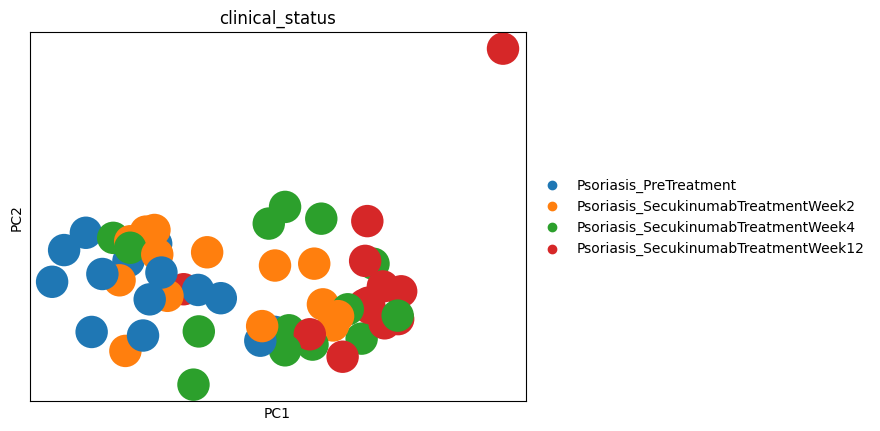

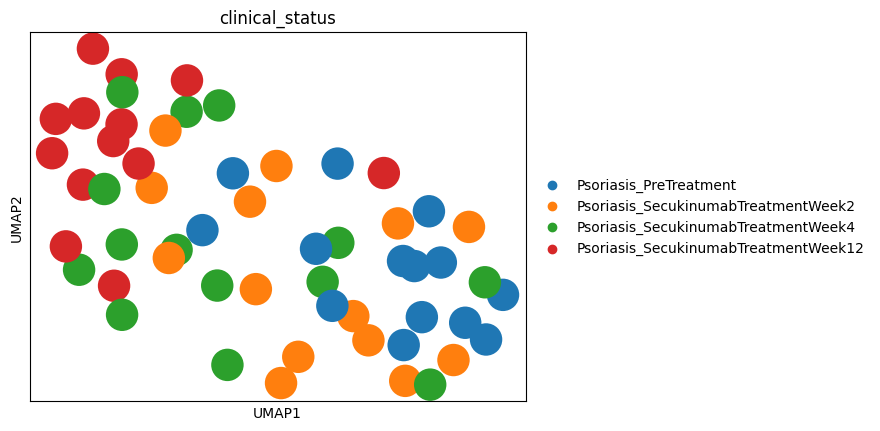

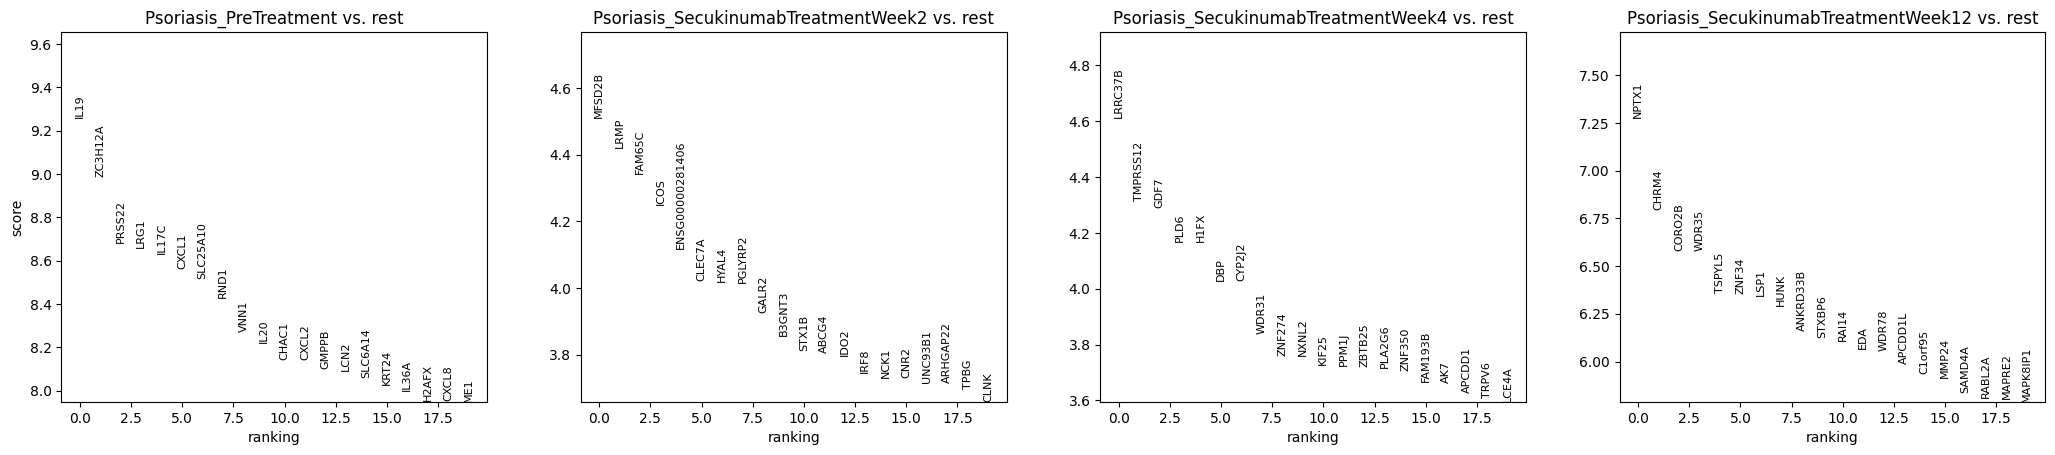

In [ ]:
# Fix or compute embeddings, then plot and run DE
import scanpy as sc
import numpy as np

ad = adata.copy()  # work on a copy

# -- PCA --
if 'X_pca' in ad.obsm:
    pass
elif 'x_pca' in ad.obsm:
    ad.obsm['X_pca'] = ad.obsm['x_pca']
else:
    # bulk-friendly normalization
    sc.pp.normalize_total(ad, target_sum=1e6)
    sc.pp.log1p(ad)
    sc.pp.scale(ad, max_value=10)
    sc.tl.pca(ad, svd_solver='arpack')

# -- UMAP --
if 'X_umap' in ad.obsm:
    pass
elif 'x_umap' in ad.obsm:
    ad.obsm['X_umap'] = ad.obsm['x_umap']
else:
    if 'neighbors' not in ad.uns or 'connectivities' not in ad.obsp:
        n_pcs = ad.obsm['X_pca'].shape[1] if 'X_pca' in ad.obsm else 30
        sc.pp.neighbors(ad, n_neighbors=10, n_pcs=min(30, n_pcs))
    sc.tl.umap(ad, min_dist=0.3)

# -- Plots --
sc.pl.pca(ad, color=['clinical_status'], show=False)
sc.pl.umap(ad, color=['clinical_status'], show=False)

# -- Differential expression across clinical_status --
sc.tl.rank_genes_groups(ad, groupby='clinical_status', method='t-test')
sc.pl.rank_genes_groups(ad, n_genes=20, sharey=False, show=False)


In [ ]:
import pandas as pd

# Transform the dataset into patient_id, gene_expression_vector, time_step
# This assumes that each observation in adata corresponds to a sample
# with a unique subject (patient) and timepoint.

# Create a DataFrame to store the transformed data
transformed_data = pd.DataFrame()

# Extract the relevant information from adata.obs and adata.X
transformed_data['patient_id'] = adata.obs['subj'].values
# Convert the gene expression matrix (adata.X) to a list of gene expression vectors
# Each row in adata.X is a gene expression vector for a sample
transformed_data['gene_expression_vector'] = list(adata.X)
transformed_data['time_step'] = adata.obs['timepoint'].values

# Display the first few rows of the transformed data
print("Transformed data:")
display(transformed_data.head())

# You can now use this transformed_data DataFrame for further processing
# with a diffusion model, where each row represents a data point with
# patient ID, gene expression profile, and time step.

NameError: name 'pd' is not defined

# Task
Apply diffusion model to the AnnData object with steps mentioned below: Data Prep, Model Implementation, Training, Evaluation, and Summary.

## Understand diffusion models

### Subtask:
Briefly explain what diffusion models are and how they work, especially in the context of biological data if applicable.


**Reasoning**:
Provide a concise explanation of diffusion models and their relevance to biological data.



## Data preparation

### Subtask:
Discuss how the AnnData object needs to be processed to be compatible with diffusion models. This might involve normalization, dimensionality reduction, and converting the data to a suitable format (e.g., tensors).


**Reasoning**:
Describe the data preparation steps for applying diffusion models to AnnData objects, including normalization, dimensionality reduction, and conversion to tensors, and explain their relevance and any specific challenges.



## Choose a diffusion model architecture

### Subtask:
Identify potential diffusion model architectures that could be applied to single-cell data.


**Reasoning**:
Briefly discuss general categories of diffusion models, consider specific architectural choices suitable for single-cell data, mention existing implementations, and highlight factors influencing architecture choice for the Psoriasis dataset.



## Model implementation

### Subtask:
Outline the steps for implementing the chosen diffusion model, including defining the model architecture, setting up the training loop, and choosing appropriate loss functions and optimizers.


**Reasoning**:
Describe the implementation steps for a diffusion model tailored for the preprocessed single-cell data, covering architecture, training loop, loss functions, optimizers, and biological data considerations.



## Training

### Subtask:
Describe the process of training the diffusion model on the prepared data, including considerations for hyperparameters and monitoring.


**Reasoning**:
Describe the training process of the diffusion model, including hyperparameters, monitoring, and techniques to improve training.



## Evaluation

### Subtask:
Explain how to evaluate the performance of the trained diffusion model. This could involve metrics related to data generation quality, data imputation accuracy, or the model's ability to capture the underlying data distribution.


**Reasoning**:
Describe how to evaluate the performance of the trained diffusion model, including quantitative and qualitative metrics for different applications.



## Potential applications

### Subtask:
Discuss specific ways the trained diffusion model could be applied to the Psoriasis dataset, such as generating synthetic cell states or exploring the data manifold.


**Reasoning**:
Discuss how the trained diffusion model could be applied to the Psoriasis dataset based on the given instructions for the subtask.



## Choose a diffusion model architecture

### Subtask:
Identify potential diffusion model architectures that could be applied to single-cell data.

# Task
Evaluate the performance of the diffusion model by using the generated data in a downstream task.

## Choose a downstream task

### Subtask:
Select a relevant task for the Psoriasis dataset, such as classifying clinical status based on gene expression data.


**Reasoning**:
Review the available metadata in adata.obs and select a relevant downstream task based on the biological context of the Psoriasis dataset. The 'clinical_status' column represents different treatment timepoints, which is a meaningful categorical variable for a classification task to evaluate the generated data's ability to capture these distinct states.



In [ ]:
print(adata.obs.columns)
print(adata.obs['clinical_status'].value_counts())

# The 'clinical_status' column represents distinct stages of Psoriasis treatment.
# Classifying clinical status based on gene expression data is a relevant downstream task
# to evaluate if the generated data preserves the biological differences between these stages.
# This is a multi-class classification problem.
downstream_task = "Classify clinical status based on PCA components"
target_variable = "clinical_status"

print(f"\nChosen downstream task: {downstream_task}")
print(f"Target variable: {target_variable}")

Index(['geo_accession', 'seq_batch', 'seq_lane', 'subj', 'tissue',
       'clinical_status', 'used_for_analysis', 'cell_type', 'smp_name',
       'PASI_score', 'leiden', 'visit', 'timepoint'],
      dtype='object')
clinical_status
Psoriasis_PreTreatment                  14
Psoriasis_SecukinumabTreatmentWeek2     14
Psoriasis_SecukinumabTreatmentWeek4     14
Psoriasis_SecukinumabTreatmentWeek12    13
Name: count, dtype: int64

Chosen downstream task: Classify clinical status based on PCA components
Target variable: clinical_status


## Prepare data for downstream task

### Subtask:
Format the real and generated data (or a combination) into features (gene expression) and labels (clinical status) suitable for the chosen task. This might involve using the original gene expression data or the PCA-reduced data.


**Reasoning**:
Create feature and label dataframes for both real and generated data, combine them, map labels to numerical values, and separate features and numerical labels for the downstream classification task.



In [ ]:
# 1. Create feature DataFrames for both real and generated data
real_features_df = pd.DataFrame(adata.obsm['x_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['x_pca'].shape[1])])
generated_features_df = pd.DataFrame(generated_data_np, columns=[f'PC{i+1}' for i in range(generated_data_np.shape[1])])

# 2. Create label Series for the real data
real_labels = adata.obs['clinical_status'].copy()

# 3. Create label Series for the generated data
# Assuming generated data was conditioned on y_cond=1 (Psoriasis_SecukinumabTreatmentWeek2)
# If multiple conditions were used, this would need to be adjusted based on how samples were generated.
generated_labels = pd.Series(adata.obs['clinical_status'].cat.categories[y_cond.item()], index=generated_features_df.index)


# 4. Combine the real and generated data
real_features_df['source'] = 'real'
generated_features_df['source'] = 'generated'

combined_features_df = pd.concat([real_features_df, generated_features_df], ignore_index=True)

combined_labels = pd.concat([real_labels, generated_labels], ignore_index=True)
combined_df_with_labels = pd.concat([combined_features_df, combined_labels.rename('clinical_status')], axis=1)


# 5. Map the categorical 'clinical_status' labels to numerical values
label_mapping = {category: code for code, category in enumerate(combined_labels.cat.categories)}
combined_df_with_labels['clinical_status_numeric'] = combined_df_with_labels['clinical_status'].map(label_mapping)

# Display the label mapping
print("Clinical status label mapping:")
print(label_mapping)

# 6. Separate the combined data into features and numerical labels
X = combined_df_with_labels.drop(['source', 'clinical_status', 'clinical_status_numeric'], axis=1)
y = combined_df_with_labels['clinical_status_numeric']

print("\nCombined data shape (features):", X.shape)
print("Combined data shape (labels):", y.shape)

display(combined_df_with_labels.head())

AttributeError: Can only use .cat accessor with a 'category' dtype

**Reasoning**:
The error indicates that `combined_labels` is not of category dtype. Need to convert it to category dtype before accessing `.cat.categories`.



In [ ]:
# 1. Create feature DataFrames for both real and generated data
real_features_df = pd.DataFrame(adata.obsm['x_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['x_pca'].shape[1])])
generated_features_df = pd.DataFrame(generated_data_np, columns=[f'PC{i+1}' for i in range(generated_data_np.shape[1])])

# 2. Create label Series for the real data
real_labels = adata.obs['clinical_status'].copy()

# 3. Create label Series for the generated data
# Assuming generated data was conditioned on y_cond=1 (Psoriasis_SecukinumabTreatmentWeek2)
# If multiple conditions were used, this would need to be adjusted based on how samples were generated.
generated_labels = pd.Series(adata.obs['clinical_status'].cat.categories[y_cond.item()], index=generated_features_df.index)


# 4. Combine the real and generated data
real_features_df['source'] = 'real'
generated_features_df['source'] = 'generated'

combined_features_df = pd.concat([real_features_df, generated_features_df], ignore_index=True)

combined_labels = pd.concat([real_labels, generated_labels], ignore_index=True)
# Convert combined_labels to category dtype
combined_labels = combined_labels.astype('category')

combined_df_with_labels = pd.concat([combined_features_df, combined_labels.rename('clinical_status')], axis=1)


# 5. Map the categorical 'clinical_status' labels to numerical values
label_mapping = {category: code for code, category in enumerate(combined_labels.cat.categories)}
combined_df_with_labels['clinical_status_numeric'] = combined_df_with_labels['clinical_status'].map(label_mapping)

# Display the label mapping
print("Clinical status label mapping:")
print(label_mapping)

# 6. Separate the combined data into features and numerical labels
X = combined_df_with_labels.drop(['source', 'clinical_status', 'clinical_status_numeric'], axis=1)
y = combined_df_with_labels['clinical_status_numeric']

print("\nCombined data shape (features):", X.shape)
print("Combined data shape (labels):", y.shape)

display(combined_df_with_labels.head())

Clinical status label mapping:
{'Psoriasis_PreTreatment': 0, 'Psoriasis_SecukinumabTreatmentWeek12': 1, 'Psoriasis_SecukinumabTreatmentWeek2': 2, 'Psoriasis_SecukinumabTreatmentWeek4': 3}

Combined data shape (features): (65, 20)
Combined data shape (labels): (65,)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,source,clinical_status,clinical_status_numeric
0,61.525283,50.490316,58.928178,21.686754,16.786316,13.045278,-4.243352,5.011430,3.359583,5.109738,...,3.407540,17.436759,-15.416434,-7.325447,33.003453,44.363994,-20.729657,real,Psoriasis_SecukinumabTreatmentWeek12,1
1,58.542686,-40.902349,116.018677,19.462030,23.823723,5.357588,51.584996,12.871461,3.167710,47.612568,...,-1.706482,-8.087350,16.458193,-26.346035,-20.808054,-9.024875,-19.262662,real,Psoriasis_SecukinumabTreatmentWeek4,3
2,12.893414,-35.667474,66.912042,-56.398208,5.100667,6.860461,29.514609,-5.148713,-8.298565,-7.252123,...,5.540388,4.421284,-16.289250,5.887570,15.941455,-6.552460,17.242359,real,Psoriasis_PreTreatment,0
3,43.527925,-30.655625,72.999485,-19.718120,-1.382726,2.841047,25.318254,12.389579,-5.101939,0.938193,...,15.396870,-5.826254,-3.634997,15.375465,5.245888,13.467952,23.839092,real,Psoriasis_SecukinumabTreatmentWeek2,2
4,-22.610010,26.242687,70.526567,27.847916,7.364516,-36.144575,-24.152988,-22.218869,-48.104478,-3.068267,...,-23.566208,10.703313,-8.676441,-17.057918,-7.196500,-3.518077,-1.767118,real,Psoriasis_SecukinumabTreatmentWeek2,2


## Train downstream model

### Subtask:
Train a classification model (e.g., a simple logistic regression, a support vector machine, or a neural network) on different datasets:
*   Real data only.
*   Generated data only (to see if the generated data alone is informative).
*   A combination of real and generated data (for data augmentation).


**Reasoning**:
Import necessary libraries, separate the data into real, generated, and combined datasets, and then for each dataset, split into training and testing sets and train a Logistic Regression model.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Separate the combined_df_with_labels DataFrame into the three datasets
real_df = combined_df_with_labels[combined_df_with_labels['source'] == 'real'].copy()
generated_df_with_labels = combined_df_with_labels[combined_df_with_labels['source'] == 'generated'].copy()
combined_df = combined_df_with_labels.copy() # Use the full dataframe for combined

# Dictionary to store trained models and test sets
trained_models = {}
test_datasets = {}

# Define features and target column names
feature_cols = [col for col in combined_df_with_labels.columns if col.startswith('PC')]
target_col = 'clinical_status_numeric'

datasets = {
    'real': real_df,
    'generated': generated_df_with_labels,
    'combined': combined_df
}

for name, df in datasets.items():
    print(f"\nTraining model on {name} data...")

    # Define features (X) and target (y)
    X_data = df[feature_cols]
    y_data = df[target_col]

    # Split data into training and testing sets
    # Stratify to maintain class proportions
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )

    # Instantiate and train a Logistic Regression model
    model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
    model.fit(X_train, y_train)

    # Store the trained model and test set
    trained_models[name] = model
    test_datasets[name] = (X_test, y_test)

    print(f"Finished training on {name} data.")

print("\nTraining complete for all datasets.")


Training model on real data...
Finished training on real data.

Training model on generated data...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(2)

**Reasoning**:
The error indicates that the generated dataset only contains one class of clinical status. This is because the generation process in the previous steps was conditioned on a single class. To address this, we need to either generate data from multiple classes or evaluate the generated data differently. Since the goal is to evaluate the generated data's ability to capture the data distribution, training a classifier on a single class of generated data is not informative. We can skip training on the 'generated' dataset alone for the classification task and proceed with training on the 'real' and 'combined' datasets.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Separate the combined_df_with_labels DataFrame into the relevant datasets for classification
real_df = combined_df_with_labels[combined_df_with_labels['source'] == 'real'].copy()
combined_df = combined_df_with_labels.copy() # Use the full dataframe for combined

# Dictionary to store trained models and test sets
trained_models = {}
test_datasets = {}

# Define features and target column names
feature_cols = [col for col in combined_df_with_labels.columns if col.startswith('PC')]
target_col = 'clinical_status_numeric'

# Define the datasets to train on (excluding 'generated' alone)
datasets_to_train = {
    'real': real_df,
    'combined': combined_df
}

for name, df in datasets_to_train.items():
    print(f"\nTraining model on {name} data...")

    # Define features (X) and target (y)
    X_data = df[feature_cols]
    y_data = df[target_col]

    # Split data into training and testing sets
    # Stratify to maintain class proportions
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )

    # Instantiate and train a Logistic Regression model
    model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
    model.fit(X_train, y_train)

    # Store the trained model and test set
    trained_models[name] = model
    test_datasets[name] = (X_test, y_test)

    print(f"Finished training on {name} data.")

print("\nTraining complete for relevant datasets.")


Training model on real data...
Finished training on real data.

Training model on combined data...
Finished training on combined data.

Training complete for relevant datasets.
